In [29]:
import spotipy
import spotipy.util as util
from spotipy.oauth2 import SpotifyClientCredentials

import pandas as pd
import numpy as np

import json

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [2]:
CLIENT_ID = "46caa64bfab44809a68d8f6fed02fdff"

CLIENT_SECRET = "bd9b5b2a5246493b9695e2fb3cb81077"

In [3]:
token = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)

cache_token = token.get_access_token()
sp = spotipy.Spotify(cache_token)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: You're using 'as_dict = True'.get_access_token will return the token string directly in future versions. Please adjust your code accordingly, or use get_cached_token instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
#dictionary holding our three playlists' information, obviously editable by users later on 
pl_dict = {
    "United States Top 50" : ("spotifycharts", "37i9dQZEVXbLRQDuF5jeBp"),
    "United Kingdom Top 50" : ("spotifycharts", "37i9dQZEVXbLnolsZ8PSNw"),
    "Global Top 50" : ("spotifycharts", "37i9dQZEVXbMDoHDwVN2tF"),
    #"United States Viral 50" : ("spotifycharts", "37i9dQZEVXbKuaTI1Z1Afx"),
    #"United Kingdom Viral 50" : ("spotifycharts", "37i9dQZEVXbL3DLHfQeDmV"),
    #"Global Viral 50" : ("spotifycharts", "37i9dQZEVXbLiRSasKsNU9")
}

#the features of each track that we want to obtain
track_features = ['artist', 'track', 'album', 'id', 'danceability', 'energy', 'key',
               'loudness', 'mode', 'speechiness', 'instrumentalness', 'tempo', 'liveness', 'duration_ms']

def playlist(username, id_):
    #create a dataframe to store all our tracks
    df = pd.DataFrame(columns=track_features)
    
    #call the API to return a playlist (in our case, top 50 charts)
    playlist = sp.user_playlist_tracks(username, id_)
    
    #as shown above, we need to extract the information from items
    tracks = playlist["items"]
    
    for track in tracks:
        features = {}
        
        #navigating through the output from the spotify API and gathering categorical data for each track
        features['track'] = track['track']['name']
        features['album'] = track['track']['album']['name']
        features['artist'] = track['track']['album']['artists'][0]['name']
        features['id'] = track['track']['id']
        
        #we want audio (mostly numerical) data for each track
        audio = sp.audio_features(features['id'])[0]
        #the audio features of each track
        audio_features = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 
                          'instrumentalness', 'tempo', 'liveness', 'duration_ms']
        
        for feature in audio_features:
            features[feature] = audio[feature]
        
        #concat each track's dataframe with the overall playlist dataframe
        temp_df = pd.DataFrame(features, index=[0])
        df = pd.concat([df, temp_df], ignore_index=True)
    
    return df  


def playlists(playlist_dictionary):
    output = pd.DataFrame(columns=track_features)
    
    for (k, v) in playlist_dictionary.items():
        df = playlist(v[0], v[1])
        
        output = pd.concat([output, df], ignore_index=True)
    
    return output

In [5]:
all_tracks = playlists(pl_dict)
all_tracks = all_tracks.drop_duplicates(subset='track', keep='first')

top5_artists = all_tracks['artist'].value_counts()[:5]

In [6]:
all_tracks

,artist,track,album,id,danceability,energy,key,loudness,mode,speechiness,instrumentalness,tempo,liveness,duration_ms
0,Olivia Rodrigo,good 4 u,SOUR,4ZtFanR9U6ndgddUvNcjcG,0.563,0.664,9,-5.044,1,0.1540,0,166.928,0.0849,178147
1,"Tyler, The Creator",WUSYANAME,CALL ME IF YOU GET LOST,5B0kgjHULYJhAQkK5XsMoC,0.493,0.653,0,-5.666,0,0.0466,0,142.347,0.5110,121573
2,Doja Cat,Kiss Me More (feat. SZA),Planet Her,3DarAbFujv6eYNliUTyqtz,0.764,0.705,8,-3.463,1,0.0284,8.92e-05,110.970,0.1200,208667
3,Doja Cat,You Right,Planet Her,0k4d5YPDr1r7FX77VdqWez,0.828,0.621,8,-6.414,1,0.0565,0.00233,128.986,0.0845,186173
4,"Tyler, The Creator",JUGGERNAUT,CALL ME IF YOU GET LOST,7z4xW9WY86uH3gd1V9pfCM,0.827,0.571,11,-7.949,1,0.3660,0,142.034,0.1660,146419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,Måneskin,ZITTI E BUONI,Teatro d'ira - Vol. I,776AftMmFFAWUIEAb3lHhw,0.625,0.939,4,-3.115,0,0.0669,0,102.999,0.4240,194787
138,J Balvin,Poblado - Remix,Poblado (Remix),1WedZeiezCmCEOzLwhx0hV,0.813,0.809,3,-5.382,0,0.0846,1.37e-06,93.005,0.3770,393280
139,Trinidad Cardona,Dinero,Dinero,3ggtU1ZOKO8ZNiqPNyXGcm,0.708,0.782,2,-4.687,1,0.0674,0,119.997,0.1070,160880
144,BTS,Dynamite,BE,4saklk6nie3yiGePpBwUoc,0.746,0.765,6,-4.410,0,0.0993,0,114.044,0.0936,199054


In [7]:
top5_artists

Tyler, The Creator    15
Olivia Rodrigo         8
Doja Cat               7
Måneskin               3
Mimi Webb              2
Name: artist, dtype: int64

In [8]:
all_tracks.columns

Index(['artist', 'track', 'album', 'id', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'instrumentalness', 'tempo',
       'liveness', 'duration_ms'],
      dtype='object')

In [9]:
X = all_tracks[all_tracks.columns[4:]]
X = StandardScaler().fit_transform(X)

pca = PCA(n_components=2)
pC = pca.fit_transform(X)

pDF = pd.DataFrame(data=pC, columns=['principal component 1', 'principal component 2'])

pDF

,principal component 1,principal component 2
0,0.481924,0.550070
1,0.812070,0.721143
2,-1.373610,-0.780541
3,-0.119381,-0.480146
4,1.313445,1.466206
...,...,...
83,-2.002550,0.931771
84,-1.566913,-0.467616
85,-0.755138,-0.807409
86,-1.557985,0.161996


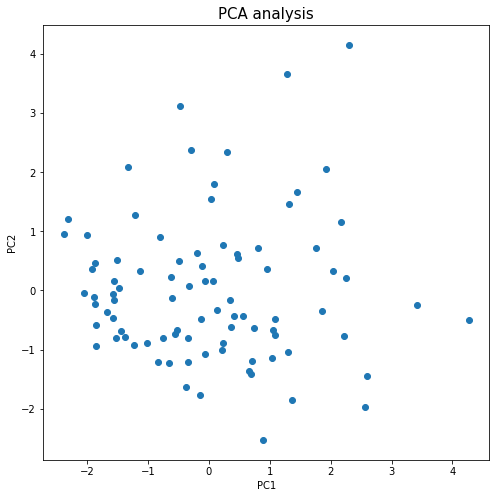

In [10]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.set_xlabel('PC1', fontsize=10)
ax.set_ylabel('PC2', fontsize=10)
ax.set_title('PCA analysis', fontsize=15)

ax.scatter(pDF['principal component 1'], pDF['principal component 2'])

In [12]:
dbs = DBSCAN(min_samples=5)

dbs.fit(pDF[['principal component 1', 'principal component 2']])

DBSCAN(algorithm='auto', eps=0.5, leaf_size=30, metric='euclidean',
       metric_params=None, min_samples=5, n_jobs=None, p=None)

In [13]:
pDF['dbscan label'] = np.array(dbs.labels_)

pDF = pDF[pDF['dbscan label'] != -1]
labels = pDF['dbscan label']

In [14]:
pDF

,principal component 1,principal component 2,dbscan label
0,0.481924,0.550070,0
2,-1.373610,-0.780541,0
3,-0.119381,-0.480146,0
7,0.348816,-0.164782,0
8,-2.047311,-0.046883,0
13,0.559824,-0.430612,0
14,0.701450,-1.414176,0
20,-1.554166,-0.158442,0
21,0.419364,-0.429286,0
23,0.371796,-0.625951,0


In [15]:
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print("\nClusters discovered: %d" % n_clusters_)


Clusters discovered: 1


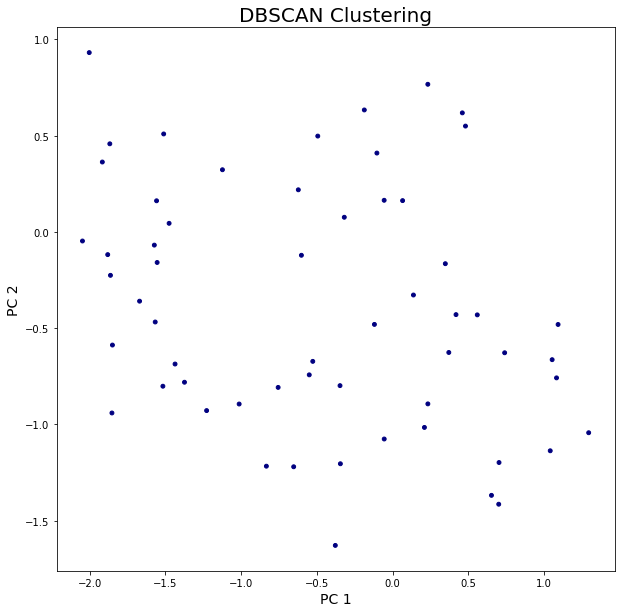

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(pDF['principal component 1'], pDF['principal component 2'], 
            c=pDF['dbscan label'], s=15, cmap='jet')

plt.title('DBSCAN Clustering',fontsize=20)
plt.xlabel('PC 1',fontsize=14)
plt.ylabel('PC 2',fontsize=14)

plt.show()

In [17]:
result = pd.concat([pDF, all_tracks[all_tracks.columns[:4]]], axis=1)

result

,principal component 1,principal component 2,dbscan label,artist,track,album,id
0,0.481924,0.550070,0.0,Olivia Rodrigo,good 4 u,SOUR,4ZtFanR9U6ndgddUvNcjcG
1,NaN,NaN,NaN,"Tyler, The Creator",WUSYANAME,CALL ME IF YOU GET LOST,5B0kgjHULYJhAQkK5XsMoC
2,-1.373610,-0.780541,0.0,Doja Cat,Kiss Me More (feat. SZA),Planet Her,3DarAbFujv6eYNliUTyqtz
3,-0.119381,-0.480146,0.0,Doja Cat,You Right,Planet Her,0k4d5YPDr1r7FX77VdqWez
4,NaN,NaN,NaN,"Tyler, The Creator",JUGGERNAUT,CALL ME IF YOU GET LOST,7z4xW9WY86uH3gd1V9pfCM
...,...,...,...,...,...,...,...
135,NaN,NaN,NaN,Måneskin,ZITTI E BUONI,Teatro d'ira - Vol. I,776AftMmFFAWUIEAb3lHhw
138,NaN,NaN,NaN,J Balvin,Poblado - Remix,Poblado (Remix),1WedZeiezCmCEOzLwhx0hV
139,NaN,NaN,NaN,Trinidad Cardona,Dinero,Dinero,3ggtU1ZOKO8ZNiqPNyXGcm
144,NaN,NaN,NaN,BTS,Dynamite,BE,4saklk6nie3yiGePpBwUoc


In [18]:
result.dropna(inplace=True)
result.drop(result.columns[:2], axis=1, inplace=True)
result.sort_values(by=['dbscan label'], ascending=True, inplace=True)

result

,dbscan label,artist,track,album,id
0,0.0,Olivia Rodrigo,good 4 u,SOUR,4ZtFanR9U6ndgddUvNcjcG
42,0.0,Doja Cat,Woman,Planet Her,6Uj1ctrBOjOas8xZXGqKk4
43,0.0,"Tyler, The Creator",SAFARI,CALL ME IF YOU GET LOST,09xpQPfKWdio1wx6v17dGa
44,0.0,Olivia Rodrigo,"jealousy, jealousy",SOUR,0MMyJUC3WNnFS1lit5pTjk
45,0.0,Maroon 5,Beautiful Mistakes (feat. Megan Thee Stallion),JORDI (Deluxe),5zFglKYiknIxks8geR8rcL
46,0.0,Saweetie,Best Friend (feat. Doja Cat),Best Friend (feat. Doja Cat) [Remix EP] [Exten...,20BOju91NaEFK5Py4VJ2pp
49,0.0,DaBaby,Red Light Green Light,Red Light Green Light,1YDebgap5OFwXEBG18NJvy
56,0.0,KSI,Holiday,Holiday,6nV2dFZXpv1JlqDWBeTXRl
57,0.0,Galantis,Heartbreak Anthem (with David Guetta & Little ...,Heartbreak Anthem (with David Guetta & Little ...,5K6Ssv4Z3zRvxt0P6EKUAP
58,0.0,Tion Wayne,"Body (Remix) [feat. ArrDee, E1 (3x3), ZT (3x3)...","Body (Remix) [feat. ArrDee, E1 (3x3), ZT (3x3)...",6uvMKqNlrSvcC4NaKnrwjZ


In [26]:
output = result
output['dbscan label'] = result['dbscan label'].apply(lambda x: int(x+1))

output

,dbscan label,artist,track,album,id
0,2,Olivia Rodrigo,good 4 u,SOUR,4ZtFanR9U6ndgddUvNcjcG
1,2,Doja Cat,Woman,Planet Her,6Uj1ctrBOjOas8xZXGqKk4
2,2,"Tyler, The Creator",SAFARI,CALL ME IF YOU GET LOST,09xpQPfKWdio1wx6v17dGa
3,2,Olivia Rodrigo,"jealousy, jealousy",SOUR,0MMyJUC3WNnFS1lit5pTjk
4,2,Maroon 5,Beautiful Mistakes (feat. Megan Thee Stallion),JORDI (Deluxe),5zFglKYiknIxks8geR8rcL
5,2,Saweetie,Best Friend (feat. Doja Cat),Best Friend (feat. Doja Cat) [Remix EP] [Exten...,20BOju91NaEFK5Py4VJ2pp
6,2,DaBaby,Red Light Green Light,Red Light Green Light,1YDebgap5OFwXEBG18NJvy
7,2,KSI,Holiday,Holiday,6nV2dFZXpv1JlqDWBeTXRl
8,2,Galantis,Heartbreak Anthem (with David Guetta & Little ...,Heartbreak Anthem (with David Guetta & Little ...,5K6Ssv4Z3zRvxt0P6EKUAP
9,2,Tion Wayne,"Body (Remix) [feat. ArrDee, E1 (3x3), ZT (3x3)...","Body (Remix) [feat. ArrDee, E1 (3x3), ZT (3x3)...",6uvMKqNlrSvcC4NaKnrwjZ


In [28]:
res = output.reset_index(drop=True, inplace=True)
if res is None:
    print("yep")
else:
    print("nop")

yep


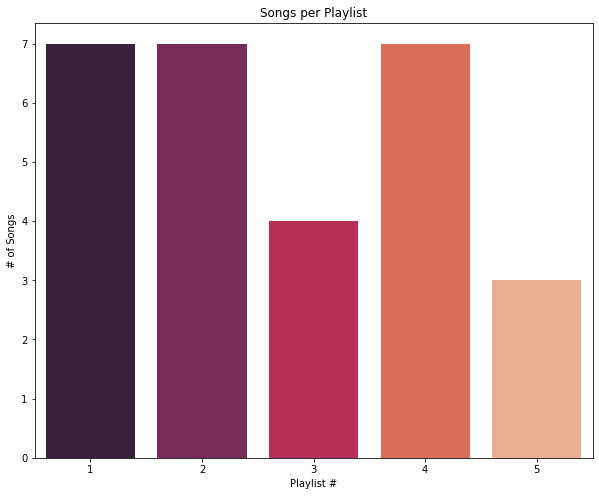

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(output['dbscan label'].value_counts().index, output['dbscan label'].value_counts(), palette="rocket")

plt.title("Songs per Playlist")
plt.xlabel("Playlist #")
plt.ylabel("# of Songs")

plt.show()